In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
north = Table.read('/Users/rongpu/Documents/Data/dr8/survey-bricks-dr8-north.fits.gz')
south = Table.read('/Users/rongpu/Documents/Data/dr8/survey-bricks-dr8-south.fits.gz')

mask = (north['dec']>32.375) & ((north['ra']>60) & (north['ra']<300))
mask &= (np.isfinite(north['galdepth_g'])) & (np.isfinite(north['galdepth_r'])) & (np.isfinite(north['galdepth_z']))
north = north[mask]
print(len(north), len(mask))
mask = ((south['dec']<=32.375) | (~((south['ra']>60) & (south['ra']<300))))
mask &= (np.isfinite(south['galdepth_g'])) & (np.isfinite(south['galdepth_r'])) & (np.isfinite(south['galdepth_z']))
south = south[mask]
print(len(south), len(mask))

82880 93610
243256 247844


In [4]:
cat = vstack([north, south])
print(len(cat))
mask_north = np.zeros(len(cat), dtype=bool)
mask_north[:len(north)] = True
mask_south = ~mask_north

cat['region'] = '     '
cat['region'][mask_south] = 'south'
cat['region'][mask_north] = 'north'

326136


In [5]:
bricks = Table.read('/Users/rongpu/Documents/Data/dr8/survey-bricks.fits.gz')
bricks.rename_column('BRICKNAME', 'brickname')
cat = join(cat, bricks[['brickname', 'RA1', 'RA2', 'DEC1', 'DEC2']], keys='brickname', join_type='inner')
print(len(cat))

326136


In [6]:
cat[:1]

brickname,ra,dec,nexp_g,nexp_r,nexp_z,nexphist_g [6],nexphist_r [6],nexphist_z [6],nobjs,npsf,nsimp,nrex,nexp,ndev,ncomp,psfsize_g,psfsize_r,psfsize_z,psfdepth_g,psfdepth_r,psfdepth_z,galdepth_g,galdepth_r,galdepth_z,ebv,trans_g,trans_r,trans_z,ext_g,ext_r,ext_z,wise_nobs [4],trans_wise [4],ext_w1,ext_w2,ext_w3,ext_w4,region,RA1,RA2,DEC1,DEC2
bytes8,float64,float64,int16,int16,int16,int32,int32,int32,int16,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,str5,float64,float64,float64,float64
0001m002,0.125,-0.25,7,7,7,14492 .. 11737771,15773 .. 11715599,20742 .. 11654312,6901,3019,0,3003,680,198,1,1.467169,1.2036675,1.176672,25.109398,25.006077,23.896887,24.857033,24.674026,23.536203,0.034025725,0.9041834,0.9344019,0.9627598,0.10935869,0.073665686,0.041205138,138 .. 12,0.99425024 .. 0.99971485,0.006260741,0.0038449126,0.0008199888,0.00030964034,south,0.0,0.25,-0.375,-0.125


In [7]:
from matplotlib.collections import PatchCollection, PolyCollection

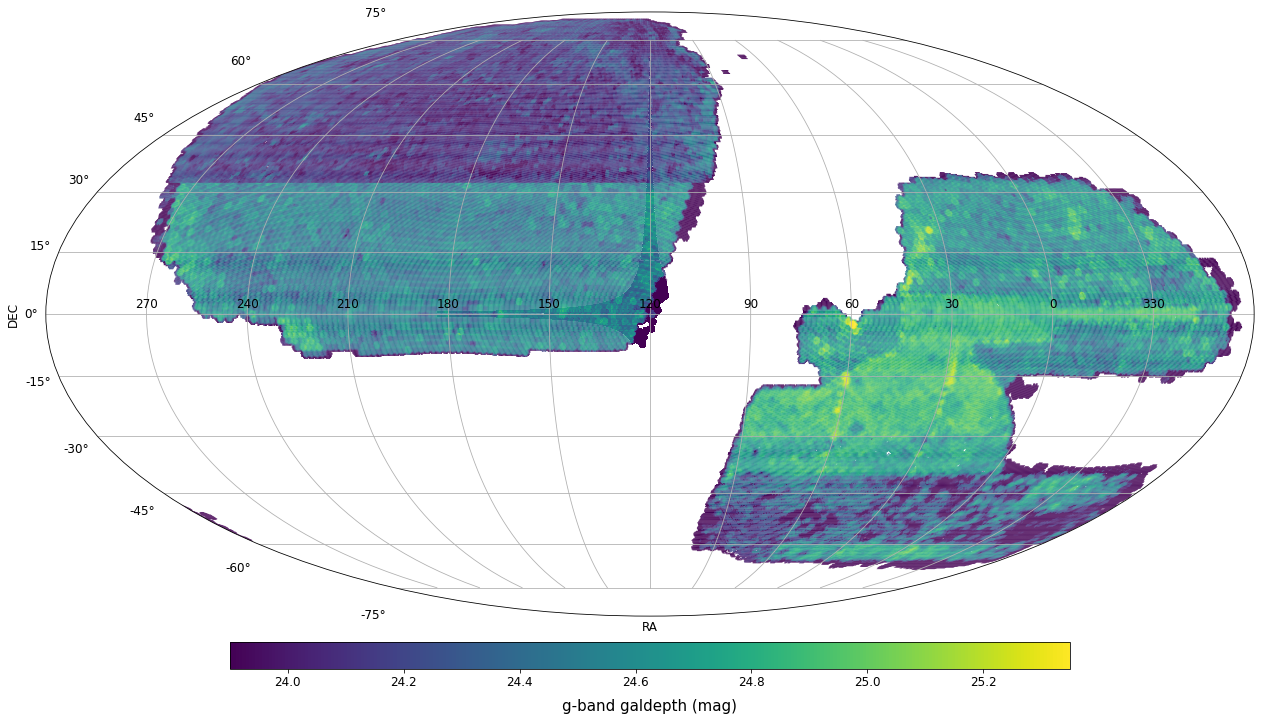

CPU times: user 8min 49s, sys: 10.3 s, total: 8min 59s
Wall time: 9min


In [8]:
%%time

mask = np.ones(len(cat), dtype=bool)
ra1, dec1, ra2, dec2, c = cat['RA1'][mask], cat['DEC1'][mask], cat['RA2'][mask], cat['DEC2'][mask], cat['galdepth_g'][mask]
# extend the brick boundaries to avoid visible boundaries in the plot
ra1, ra2 = ra1 - 0.02/np.cos(np.radians(dec1)), ra2 + 0.02/np.cos(np.radians(dec1))
dec1, dec2 = dec1 - 0.02, dec2 + 0.02
rot = 120

x1 = np.remainder(ra1+360-rot, 360) # shift ra values
x2 = ra2 + (x1-ra1)
xmask = x1>180
x1[xmask] -= 360  # scale conversion to [-180, 180]
x1 = -x1
x2[xmask] -= 360  # scale conversion to [-180, 180]
x2 = -x2
x1, x2, y1, y2 = np.radians([x1, x2, dec1, dec2])
coords = np.array([[x1, y1], [x1, y2], [x2, y2], [x2, y1]])
coords = np.swapaxes(np.swapaxes(coords, 0, 2), 1, 2)

tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
tick_labels = np.remainder(tick_labels+360+rot, 360)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='mollweide')

# idx = np.random.choice(len(cat), size=1000, replace=False)
# coords, c = coords[idx], c[idx]
collect = PolyCollection(coords, array=c)
collect.set_clim(23.9, 25.35)
collect.set_cmap('viridis')
im = ax.add_collection(collect)

ax.set_xticklabels(tick_labels)
ax.set_title('g-band galdepth (mag)', y=-0.165)
ax.title.set_fontsize(15)
ax.set_xlabel("RA")
ax.xaxis.label.set_fontsize(12)
ax.set_ylabel("DEC")
ax.yaxis.label.set_fontsize(12)
ax.grid(True)
plt.colorbar(im, orientation="horizontal", fraction=0.04, pad=0.04, aspect=32)
plt.tight_layout()
plt.savefig('/Users/rongpu/Downloads/DR8_g_band_galdepth.png', dpi=300)
plt.show()